In [1]:
import os
import sys
import glob
from obspy.core import read, UTCDateTime
import matplotlib.pyplot as plt
from obspy.io.xseed import Parser
from obspy.geodetics import gps2dist_azimuth
from obspy.taup import TauPyModel
import numpy as np
from obspy.io.xseed import Parser
from scipy.signal import hilbert, chirp
import numpy as np
from scipy import signal

# for a single event

In [36]:
# read files
dataless = '../response/ISOLDE-1.dataless'
parser = Parser(dataless)
eventname='seismo_2012-03-25T22_37_06.000000Z'
station='TDC01'
dir='tele160'
#chans=['HH1','HH2','HHZ']
chans=['BH1','BH2','BHZ']
st=read('./%s/%s/%s_%s_%s.sac'%(station,dir,eventname,station,chans[0]))
paz = parser.get_paz('1D.%s..%s'%(station,chans[0]))
st[0].simulate(paz_remove=paz,pre_filt=(0.01,0.02,1.5,2))
st.append(read('./%s/%s/%s_%s_%s.sac'%(station,dir,eventname,station,chans[1]))[0])
paz = parser.get_paz('1D.%s..%s'%(station,chans[1]))
st[1].simulate(paz_remove=paz,pre_filt=(0.01,0.02,1.5,2))
st.append(read('./%s/%s/%s_%s_%s.sac'%(station,dir,eventname,station,chans[2]))[0])
paz = parser.get_paz('1D.%s..%s'%(station,chans[2]))
st[2].simulate(paz_remove=paz,pre_filt=(0.01,0.02,1.5,2))

1D.TDC01..BHZ | 2012-03-25T22:37:06.004000Z - 2012-03-25T23:59:59.984000Z | 50.0 Hz, 248700 samples

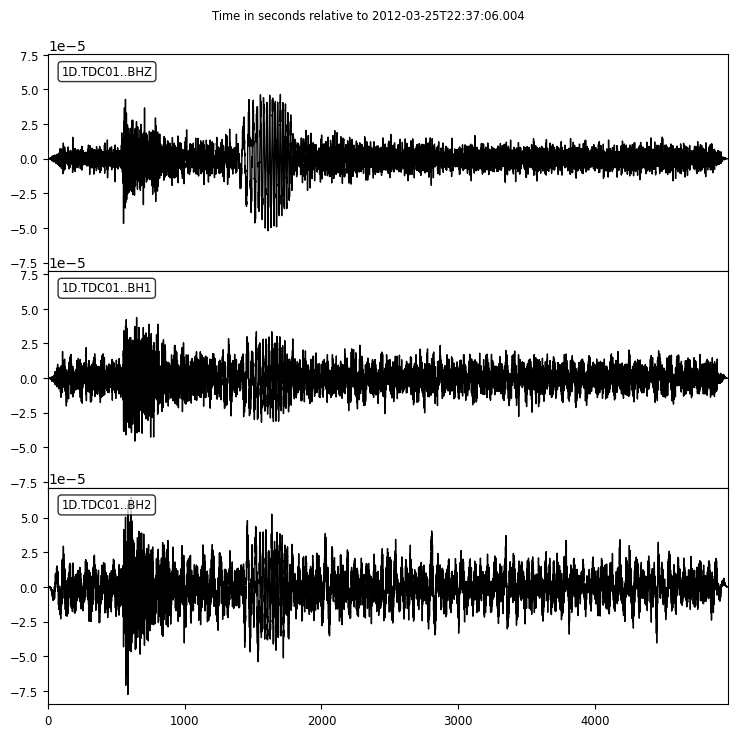

In [5]:
#plot the whole waveform
st.plot(type='relative')
plt.show()

In [7]:
# rotate function
def rotate_ne(bh1,bh2,ora):
    len1=len(bh1)
    len2=len(bh2)
    if len1!=len2:
        bh1=bh1[:min(len1,len2)]
        bh2=bh2[:min(len1,len2)]
    ora = np.radians(ora)
    n = bh1 * np.cos(ora) - bh2 * np.sin(ora)
    e = bh1 * np.sin(ora) + bh2 * np.cos(ora)
    return n, e

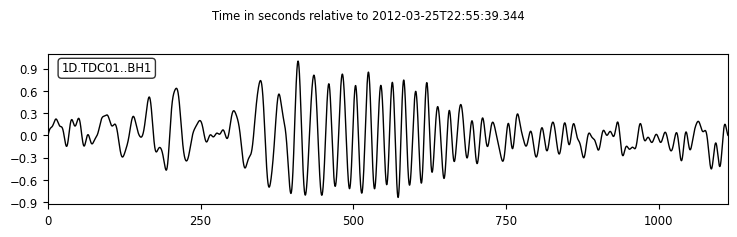

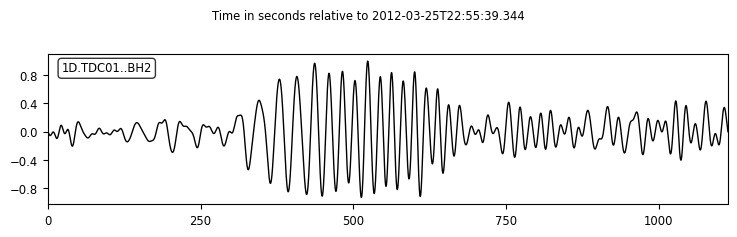

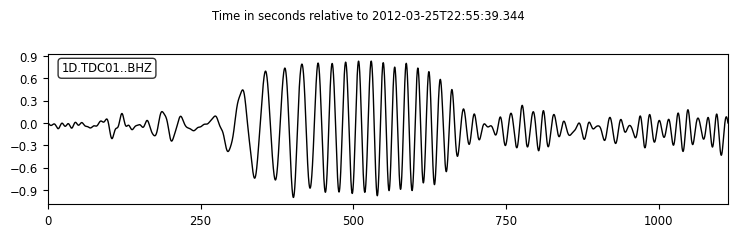

In [21]:
# cut the waveform of Rayleigh waves
tr1=st[0].filter('bandpass', freqmin=0.01, freqmax=0.1, corners=4, zerophase=True)
tr2=st[1].filter('bandpass', freqmin=0.01, freqmax=0.1, corners=4, zerophase=True).filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
tr3=st[2].filter('bandpass', freqmin=0.01, freqmax=0.1, corners=4, zerophase=True)
(dis,za,baz)=gps2dist_azimuth(st[0].stats.sac.evla, st[0].stats.sac.evlo,st[0].stats.sac.stla,st[0].stats.sac.stlo)
end=dis/2500
start=dis/5000
np1=tr1.slice(tr1.stats.starttime+start,tr1.stats.starttime+end)
np2=tr2.slice(tr2.stats.starttime+start,tr2.stats.starttime+end)
np3=tr3.slice(tr2.stats.starttime+start,tr2.stats.starttime+end)

np1.detrend()
np2.detrend()
np3.detrend()

np1.plot(type='relative')
np2.plot(type='relative')
np3.plot(type='relative')
plt.show()

In [10]:
def corr(l1,l2):
    l=l1*l2
    s=np.sum(l)
    return s

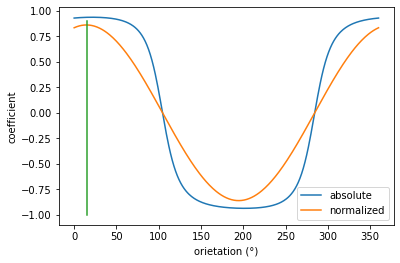

In [11]:
# calculate the coefficient curves
evlos=[]
crz=np.zeros(361)
crz2=np.zeros(361)
raz=(baz-180+360)%360
for j in range(0,361):
    i=(raz-j+360)%360
    rad=np1.data*np.cos(i/180*np.pi)+np2.data*np.sin(i/180*np.pi)
    tang=np1.data*np.cos((i+90)/180*np.pi)+np2.data*np.sin((i+90)/180*np.pi)
    h= hilbert(rad)
    hr=np.imag(h)
    evlos.append(np.abs(h))    
    corrr = corr(hr, hr,)
    corzr = corr(hr, np3.data)
    corzz = corr(np3.data,np3.data)
    crz[j]=corzr/(corzz*corrr)**(0.5)
    crz2[j]=corzr/corzz
plt.plot(crz,label='absolute')
plt.plot(crz2,label='normalized')
plt.plot(np.argmax(crz2)*np.ones(20),np.arange(-1,1,0.1))
plt.xlabel("orietation (°)") 
plt.ylabel("coefficient")
plt.legend()
plt.show()

In [18]:
y,x=np.array(evlos).shape
x=np1.stats.delta*np.arange(0,x,1)
y=np.arange(0,y,1)

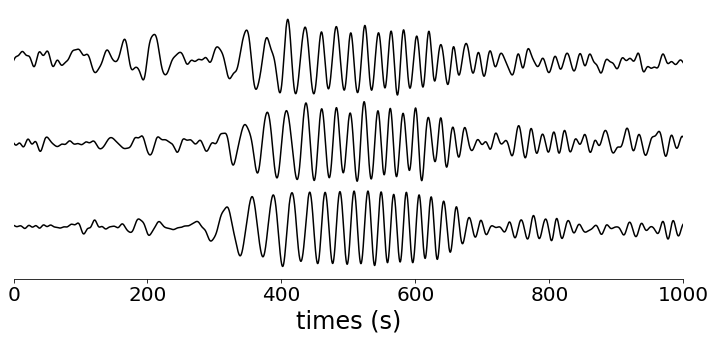

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
np1.normalize()
np2.normalize()
np3.normalize()
ax.plot(np1.times("relative"), np1.data, "k-")
ax.plot(np1.times("relative"), np2.data-2, "k-")
ax.plot(np1.times("relative"), np3.data-4, "k-")

ax.set_xlim(0,1000)
ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("times (s)",size=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.savefig('orientation1',dpi=200,format='jpg',bbox_inches='tight')

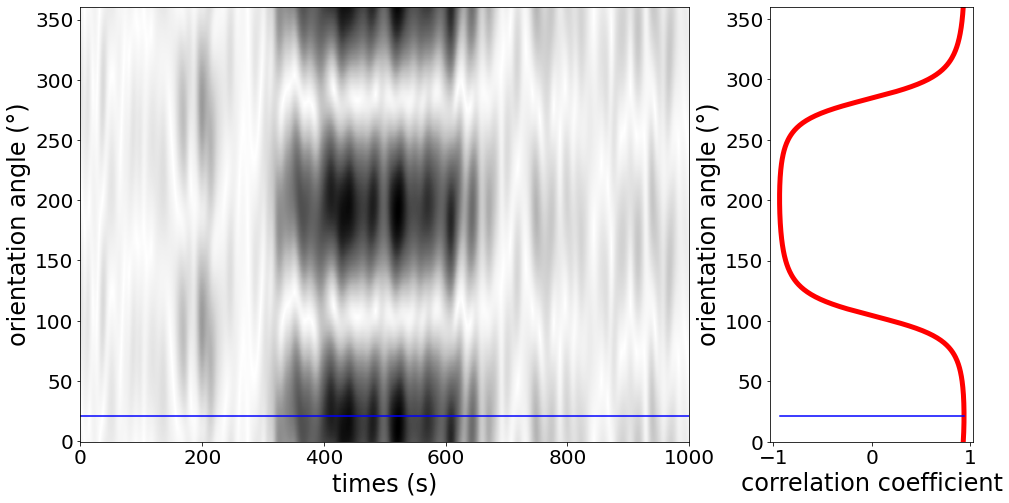

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16,8),gridspec_kw={'width_ratios': [3, 1]})

cmap = plt.get_cmap('Greys')
ax[0].pcolormesh(x,y,np.array(evlos),cmap=cmap)
ax[0].plot(np.arange(0,1500,100),np.argmax(crz)*np.ones(len(np.arange(0,1500,100))),'b')
ax[0].set_ylabel("orientation angle (°)",size=24) 
ax[0].set_xlabel("times (s)",size=24)
ax[0].set_xlim(0,1000)
ax[1].plot(crz,np.arange(0,361,1),'red',linewidth=5,label='absolute')
ax[1].plot([min(crz),max(crz)],np.argmax(crz)*np.ones(2),'b')
ax[1].set_ylabel("orientation angle (°)",size=24) 
ax[1].set_xlabel("correlation coefficient",size=24)
#plt.plot(crz2,label='normalized')
ax[1].set_ylim(0,360)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
plt.show()

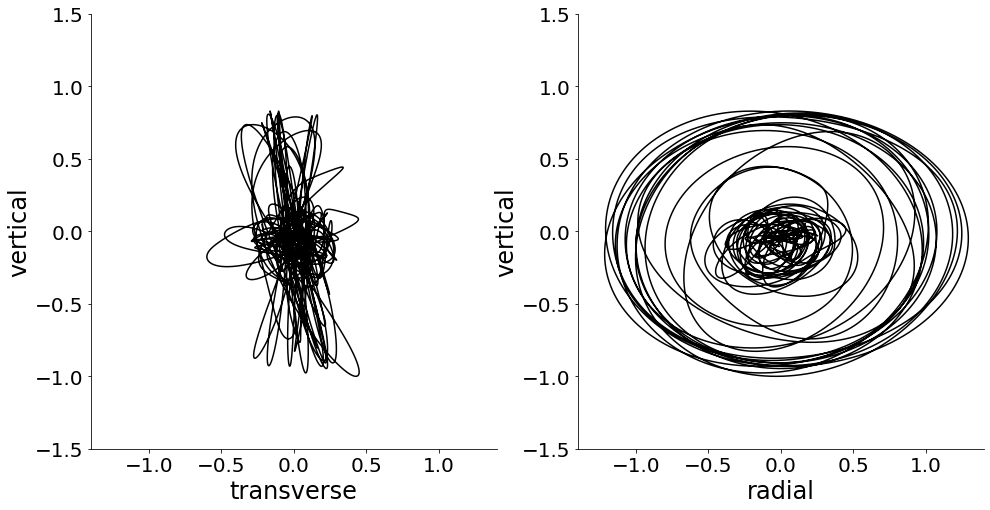

In [23]:
i=(raz-23+360)%360
rad=np1.data*np.cos(i/180*np.pi)+np2.data*np.sin(i/180*np.pi)
tang=np1.data*np.cos((i+90)/180*np.pi)+np2.data*np.sin((i+90)/180*np.pi)
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot(tang,np3,'black')
ax[1].plot(rad,np3,'black')
ax[0].axis('equal')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].axis('equal')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_ylabel("vertical",size=24)
ax[0].set_xlabel("transverse",size=24)
ax[1].set_ylabel("vertical",size=24) 
ax[1].set_xlabel("radial",size=24)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[0].set_xlim(-1.5,1.5)
ax[0].set_ylim(-1.5,1.5)
ax[1].set_xlim(-1.5,1.5)
ax[1].set_ylim(-1.5,1.5)
plt.savefig('orientation4.jpg')

# for multiple events

In [26]:
def raylei(st):
 
  st[0].detrend()
  st[1].detrend()
  st[2].detrend()
  st[0].normalize()
  st[1].normalize()
  st[2].normalize()
    
  st[0].data=st[0].data-np.mean(st[0].data)
  st[0].data=st[0].data/max(abs(st[0].data))
  st[1].data=st[1].data/max(abs(st[2].data))
  st[2].data=st[2].data/max(abs(st[2].data))


  tr1=st[0].filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
  tr2=st[1].filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
  tr3=st[2].filter('bandpass', freqmin=0.02, freqmax=0.2, corners=4, zerophase=True)
    
  st[0].data=st[0].data/max(abs(st[0].data))
  st[1].data=st[1].data/max(abs(st[1].data))
  st[2].data=st[2].data/max(abs(st[2].data))
  (dis,za,baz)=gps2dist_azimuth(st[0].stats.sac.evla, st[0].stats.sac.evlo,st[0].stats.sac.stla,st[0].stats.sac.stlo)
  end=dis/2500
  start=dis/5000
  np1=tr1.slice(tr1.stats.starttime+start,tr1.stats.starttime+end)
  np2=tr2.slice(tr2.stats.starttime+start,tr2.stats.starttime+end)
  np3=tr3.slice(tr2.stats.starttime+start,tr2.stats.starttime+end)
  np1.detrend()
  np2.detrend()
  np3.detrend()
  np1.normalize()
  np2.normalize()
  np3.normalize()
  print ('OK')
  evlos=[]
  crz=np.zeros(361)
  crz2=np.zeros(361)
  raz=(baz-180+360)%360
  for j in range(0,361):
      i=(raz-j+360)%360
      rad=np1.data*np.cos(i/180*np.pi)+np2.data*np.sin(i/180*np.pi)
      h= hilbert(rad)
      hr=np.imag(h)
      evlos.append(np.abs(h))    
      corrr = corr(hr, hr,)
      corzr = corr(hr, np3.data)
      corzz = corr(np3.data,np3.data)
      crz[j]=corzr/(corzz*corrr)**(0.5)
      crz2[j]=corzr/corzz
  return crz,crz2,evlos

def corr(l1,l2):
    l=l1*l2
    s=np.sum(l)
    return s

In [34]:
station='TDC02'
dir='tele160'
outdir='./%s/orientation/raylei/'%station
folder=os.path.exists(outdir)
if not folder:
  os.makedirs(outdir)
#read event info
evefile= '../maps/query_tele160.csv' #earthquake catlog I used for cutting sac files
op= open(evefile, "r")
line=op.readline()
count=0
az=[]
while (line!=''):
  evetime=line.split(",")[0]
  evelon=float(line.split(",")[2])
  evelat=float(line.split(",")[1])
  evedep=float(line.split(",")[3])
  evemag=float(line.split(",")[4])
  evtime=UTCDateTime(evetime.split("Z")[0])
  day=evtime.julday
  year=evtime.year
  eventname='seismo_%s'%evtime
  print('processing %s'%eventname)
  try:
    st=read('./%s/%s/%s_%s_BH1.sac'%(station,dir,eventname,station))
    st.append(read('./%s/%s/%s_%s_BH2.sac'%(station,dir,eventname,station))[0])
    st.append(read('./%s/%s/%s_%s_BHZ.sac'%(station,dir,eventname,station))[0])
    (crz,crz2,evlops)=raylei(st)
    az1=np.argmax(crz)
    max1=np.max(crz)
    az2=np.argmax(crz2)
    max2=np.max(crz2)
    az.append('%d %f %d %f'%(az1,max1,az2,max2))
    plt.figure(count)
    plt.plot(crz)
    plt.plot(crz2)

    plt.savefig('%s/result_%s.jpg'%(outdir,eventname))
    count=count+1
  except:
    print('no data')
  line=op.readline()


processing seismo_2013-01-30T23:03:43.660000Z
no data
processing seismo_2013-01-30T20:15:43.340000Z
no data
processing seismo_2013-01-28T16:38:53.580000Z
no data
processing seismo_2013-01-21T22:22:52.760000Z
no data
processing seismo_2013-01-15T16:09:37.080000Z
no data
processing seismo_2013-01-05T08:58:14.957000Z
no data
processing seismo_2012-12-21T22:28:08.570000Z
no data
processing seismo_2012-12-17T09:16:30.900000Z
no data
processing seismo_2012-12-15T19:30:02.170000Z
no data
processing seismo_2012-12-14T10:36:01.590000Z
no data
processing seismo_2012-12-11T06:18:27.330000Z
no data
processing seismo_2012-12-10T16:53:08.770000Z
no data
processing seismo_2012-12-07T18:19:06.310000Z
no data
processing seismo_2012-12-07T08:31:14.800000Z
no data
processing seismo_2012-12-07T08:18:23.130000Z
no data
processing seismo_2012-12-02T00:54:22.690000Z
no data
processing seismo_2012-11-19T09:44:34.120000Z
no data
processing seismo_2012-11-15T09:20:21.910000Z
no data
processing seismo_2012-11-14

In [39]:
#read file
station='NIG01'
outdir='./%s/orientation/raylei/'%station
outfile='orietation.dat'

op= open(outdir+outfile, "r")
or1=[]
orc1=[]
or2=[]
orc2=[]
line=op.readline()
while (line!=''):
  or1.append(int(line.split(" ")[0]))
  orc1.append(float(line.split(" ")[1]))
  or2.append(int(line.split(" ")[2]))
  orc2.append(float(line.split(" ")[3]))
  line=op.readline()
op.close()
or1=np.array(or1)
orc1=np.array(orc1)
or2=np.array(or2)
orc2=np.array(orc2)

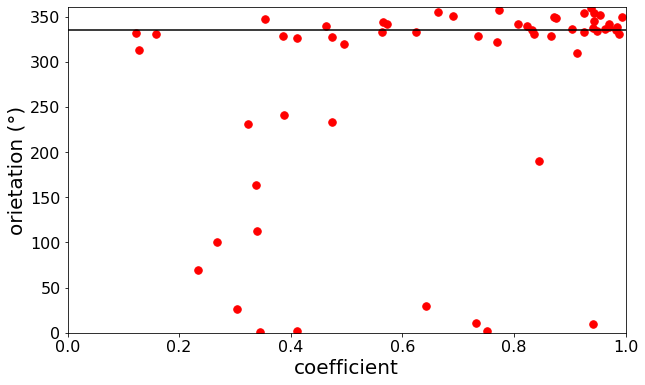

In [43]:

fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(orc1,or1,'r.',markersize=15)
plt.plot(np.arange(0,1.1,0.1),mean*np.ones(11),'black')
plt.ylabel("orietation (°)",size=20) 
plt.xlabel("coefficient",size=20)
plt.xlim(0,1)
plt.ylim(0,361)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
#plt.savefig('orientationc',dpi=300,format='tif',bbox_inches='tight')

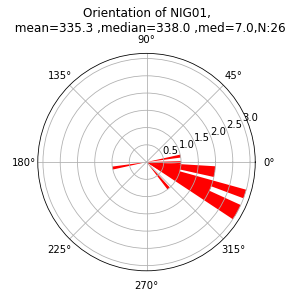

In [40]:
#calculate a reliable orientation
l=len(or1)
count=0
theta=[]

for i in range(0,l):
    if orc1[i]>0.8:
        theta.append(or1[i])
        count=count+1

mean=(np.mean((np.array(theta)+180)%360)+180)%360

median=(np.median((np.array(theta)+180)%360)+180)%360

med=np.median(abs(theta-median))


theta=np.unique(theta)
radii=np.zeros(len(theta))
for i in range(0,len(theta)):
    radii[i]=np.count_nonzero(or1==theta[i])
   

colors = plt.cm.viridis(radii )

ax = plt.subplot(projection='polar')
ax.bar(theta*np.pi/180, radii,width=5/180*np.pi, bottom=0.0, color='red')


ax.set_title("Orientation of %s,\n  mean=%0.1f ,median=%0.1f ,med=%0.1f,N:%d"%(station,mean,median,med,count), va='top')
plt.savefig('./%s_or_polar.png'%station)
plt.show()